# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from loading and inspecting the dataset; -to implementing, training and evaluating a Convolutional Neural Network based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the list of objects provided, please pick at least 3 objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is April 21st Sunday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name: Li Kailang**  

**Neptun ID: FDQAOR**

**Network: Convolutional Neural Network**

**Objects: DND**

## Task description

Your task is to train your own custom object detection model and compare its performance with an existing object detection model (i.e. YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the metrics, losses, and predictions. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your network.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
# ADD YOUR CODE HERE
import torch
import torchvision #has various utils functions, including loading datasets
import torchvision.transforms as transforms #common image transformations
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset


import torch.nn as nn #creating neural network https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F #functional api for layers,...
import torch.optim as optim #for optimization algorithm
import matplotlib.pyplot as plt #for visualization
import matplotlib.image as mpimg
import numpy as np #for basic array operations
import os
import cv2
import random

#Set up GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# 1. DATASET
For this assignment you will be using at least 3 of the [Mihály Kolodko's Mini Statues](https://www.atlasobscura.com/places/hidden-mini-statues-of-budapest).

You can find all of the objects seperately in a folder here: [Objects](https://drive.google.com/drive/folders/1QEEHye66USSWesGSVBQw1v1tk3Hr01G9?usp=sharing)

<img src='https://www.goethe.de/resources/files/jpg1201/161kolodkovojenyjkorabel-formatkey-jpg-w1920.jpg' />

### 1.1. Load objects

**Please select 3 or more objects.** Upon selecting the objects, **please remove the background, so that only the object is kept**. You can do it manually, online or by code (this is not part of the evaluation of your assignment).
As an example, the following objects have been chosen (the background was removed with Segment Anything Model):


*** before runing this code, please upload 3 images！！！ ***

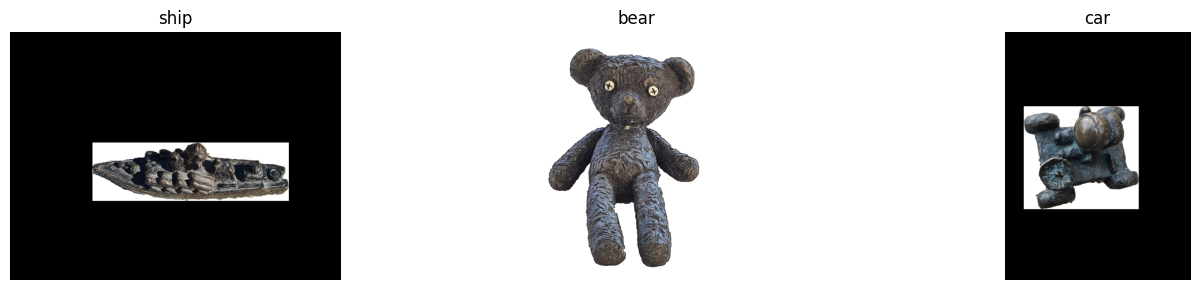

In [7]:
# ADD YOUR CODE HERE
#---------------------------------------------------------------------------------------
# 上传ps好的图片
# 检查并创建objects文件夹
dataset_dir = 'objects'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# 检查并移动上传的图片到dataset文件夹
uploaded_files = os.listdir('.')
for file_name in uploaded_files:
    if file_name.endswith('.png'):
        os.rename(file_name, os.path.join(dataset_dir, file_name))

#----------------------------------------------------------------------------------------------------
# 写一个display_objects_images(' ')函数，传入文件夹位置，对里面的图片进行可视化，上面是名字下面是图片。
def display_objects_images(image_folder_path):
  # 定义转换（Transforms），用于将图片转换成模型所需的张量
  transform = transforms.Compose([
       transforms.ToTensor()           # 转换为张量
  ])

    # 获取文件夹中的所有图片文件名
  image_filenames = os.listdir(image_folder_path)
    # 创建一个列表来存储每个图片的路径和标签
  dataset = []

  # 将每个图片的路径和标签添加到列表中
  for filename in image_filenames:
    label = os.path.splitext(filename)[0]  # 去掉文件后缀，假设文件名格式为 "label_image.png"
    image_path = os.path.join(image_folder_path, filename)
    dataset.append((image_path, label))

  # 定义一个函数来加载图片并应用转换
  def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # 以RGB模式打开图片
    image = transform(image)                      # 应用转换
    return image

  # 获取图片数量
  num_images = len(dataset)

  # 创建一个子图网格来显示图片和标签
  fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

  # 循环遍历数据集，加载图片并展示
  for i, (image_path, label) in enumerate(dataset):
    image_tensor = load_image(image_path)

    # 转换为NumPy数组，并交换轴以适应matplotlib
    image_np = image_tensor.numpy().transpose((1, 2, 0))

    # 显示图片及其标签
    axes[i].imshow(image_np)
    axes[i].set_title(label)
    axes[i].axis('off')

  # 调整布局
  plt.tight_layout()

  # 显示图片
  plt.show()

#---------------------------------------------------------------------------------------

display_objects_images('/content/objects')

In [8]:
# 加载图像
bear_img = cv2.imread('/content/objects/bear.png')
car_img = cv2.imread('/content/objects/car.png')
ship_img = cv2.imread('/content/objects/ship.png')


# 调整图像大小
desired_size = (112, 112)
bear_resized = cv2.resize(bear_img, desired_size)
car_resized = cv2.resize(car_img, desired_size)
ship_resized = cv2.resize(ship_img, desired_size)

# 将图像转换为张量
bear_tensor = torch.tensor(bear_resized)
car_tensor = torch.tensor(car_resized)
ship_tensor = torch.tensor(ship_resized)

# 打印张量的形状
print("Bear tensor shape:", bear_tensor.shape)
print("Car tensor shape:", car_tensor.shape)
print("Ship tensor shape:", ship_tensor.shape)

Bear tensor shape: torch.Size([112, 112, 3])
Car tensor shape: torch.Size([112, 112, 3])
Ship tensor shape: torch.Size([112, 112, 3])


### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:
- Inserting an object in a random position of a background image

We want to follow a similar pattern to what Mihály Kolodko did, by inserting the objects in the streets of Budapest. **Thus, collect a few background images of different locations in Budapest.** This can be done manually or via code. The recommendation is to use icrawler to collect them.

In [3]:
!pip install icrawler

In [4]:
!mkdir background

In [6]:
from icrawler.builtin import BingImageCrawler

bing_crawler = BingImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['budapest', 'budapest parliament', 'buda castle', 'budapest st stephen basilica', 'budapest heroes square']:
    bing_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto' , min_size=(500, 500),)

#Some images may return an error, but icrawler tries to find other images regardless

ERROR:downloader:Response status code 403, file https://img.itinari.com/pages/images/original/1528831f-3d25-4fd5-92de-5ad3a98b607e-istock-507837646.jpg
ERROR:downloader:Response status code 403, file https://ppcdn.500px.org/50391452/74a0c6bede75357f65daf99a9cb0ea86823a9e00/2048.jpg


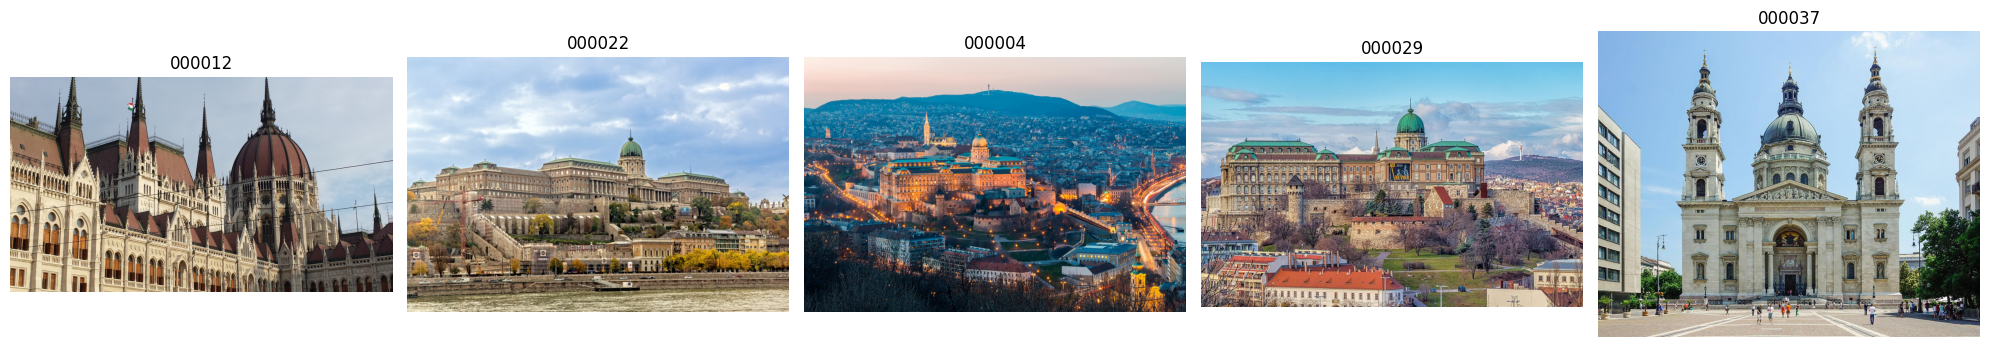

In [13]:
# 写一个display_sample_images函数

def display_sample_images(folder_path):
    # 获取文件夹中的图片文件列表
    image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    # 随机选择5张图片
    random_image_files = random.sample(image_files, min(len(image_files), 5))

    # 创建画布
    num_images = len(random_image_files)
    num_rows = 1 if num_images == 0 else (num_images + 4) // 5  # 每行显示5张图片
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows*4))

    # 遍历并显示图片
    for i, image_file in enumerate(random_image_files):
        row = 1
        col = i % 5

        # 读取图片并显示
        img = mpimg.imread(os.path.join(folder_path, image_file))
        if num_rows == 1:
            axes[col].imshow(img)
            axes[col].set_title(image_file[:-4], fontsize=12)  # 去掉文件名后缀
            axes[col].axis('off')
        else:
            axes[i // 5, col].imshow(img)
            axes[i // 5, col].set_title(image_file[:-4], fontsize=12)  # 去掉文件名后缀
            axes[i // 5, col].axis('off')

    plt.tight_layout()
    plt.show()

#-----------------------------------------------------------------------------------------
directory = '/content/background'
#Show some of the images, to confirm that they were successfully crawled
display_sample_images(directory)

### 1.3. Create dataset

Now it is time to create a dataset. This is the first important part of evaluation of the assignment.
From the selected objects and collected background images, do the following:
- Randomly select background images
- For each background image insert only 1 of the 3 select objects
- The object should be inserted at a random location
- Save the coordinates where the object was placed and create a bounding box from them. i.e. if the object with height h and width w was placed at position x,y, then the bounding box should be in the format [x,y,w,h] or [x1,y1,x2,y2] where x2=x1+w and y2=y1+h
- If you plan to compare your own custom model with a YOLO model, then use the YOLO format [((x+w/2)/image width), (x+y/2)/image height, w/image width, h/image height], where image is the background
- You may want to save the generated dataset, as it will be used later to train the custom model as well as fine-tune an existing one
- Wrap everything under a PyTorch Dataset class
- Create train, val and test sets

In [14]:
# ADD YOUR CODE HERE
#----------------------------------------------------------------------------------
# 写一个createDataset函数

#This my own function... It creates and saves a dataset in the following format:
# root/
#     dataset/
#             train/
#                   images/
#                         00001.jpg
#                   labels/
#                         00001.txt with the content [class yolo_x, yolo_y, yolo_w, yolo_h] following the yolo format
#             val
#...

def createDataset(root_dir, background_dir, split='train', img_size=(640,640), num_images=5000):
    # 创建数据集子目录
    dataset_dir = os.path.join(root_dir, 'dataset')
    split_dir = os.path.join(dataset_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    image_dir = os.path.join(split_dir, 'images')
    label_dir = os.path.join(split_dir, 'labels')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    # 从背景目录中随机选择图像
    background_images = os.listdir(background_dir)

    for i in range(num_images):
        # 从背景目录中随机选择一张图像
        background_image_name = random.choice(background_images)
        background_image_path = os.path.join(background_dir, background_image_name)

        # 加载背景图像
        background_image = cv2.imread(background_image_path)
        background_image = cv2.resize(background_image, img_size)

        #------------------------------------------------------------------------------
        # 在这里添加您的代码来处理图像，将对象放置在背景图像上，并生成相应的标签文件
        def insert_object_into_background(background_img, object_tensor):

            # 获取背景图像尺寸
            bg_height, bg_width, _ = background_img.shape

            # 获取对象张量尺寸
            obj_height, obj_width, _ = object_tensor.shape

            # 随机选择对象插入的位置
            x = random.randint(0, bg_width - obj_width)
            y = random.randint(0, bg_height - obj_height)

            # 在背景图像上插入对象
            background_image[y:y+obj_height, x:x+obj_width] = object_tensor

            # 计算并返回对象在YOLO格式下的bounding box坐标
            # 在这里假设对象在图像中的位置是(x, y)，宽度是obj_width，高度是obj_height
            # YOLO格式中的bounding box格式为 [choice, x_center, y_center, width, height]
            ob_num = 0
            if torch.equal(object_tensor, ship_tensor):
                ob_num = 1
            elif torch.equal(object_tensor, car_tensor):
                ob_num = 2
            elif torch.equal(object_tensor, bear_tensor):
                ob_num = 3


            x_center = (x + x + obj_width) / 2 / bg_width
            y_center = (y + y + obj_height) / 2 / bg_height
            width = obj_width / bg_width
            height = obj_height / bg_height

            return background_image, [ob_num, x_center, y_center, width, height]

        # 随机选择一个对象
        selected_object = random.choice([bear_tensor, ship_tensor, car_tensor])

        # 插入对象到背景图像并获取bounding box坐标
        result_image, bbox = insert_object_into_background(background_image, selected_object)

        #---------------------------------------------------------------------------------

        # 保存图像和标签文件
        image_filename = f'{i+1:05d}.jpg'
        label_filename = f'{i+1:05d}.txt'
        cv2.imwrite(os.path.join(image_dir, image_filename), result_image)
        # 保存标签文件
        label_path = os.path.join(label_dir, label_filename)
        with open(label_path, 'w') as f:
          f.write(' '.join(map(str, bbox)))

        # 进度输出
        if (i+1) % 10 == 0:
            print(f'Processed {i+1}/{num_images} images...')

    print('Dataset creation completed.')

#---------------------------------------------------------------------------------------------------------
createDataset('dataset', 'background', split='train', img_size=(640,640), num_images=50) # my GPU can not affort too much images
createDataset('dataset', 'background', split='val', img_size=(640,640), num_images=10) # the raw num_images should be *100
createDataset('dataset', 'background', split='test', img_size=(640,640), num_images=2)

Processed 10/50 images...
Processed 20/50 images...
Processed 30/50 images...
Processed 40/50 images...
Processed 50/50 images...
Dataset creation completed.
Processed 10/10 images...
Dataset creation completed.
Dataset creation completed.


In [15]:
# ADD YOUR CODE HERE
#------------------------------------------------------------------------------------
# 补全下面的类
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
       return len(self.image_filenames)
       # pass

    def __getitem__(self, idx):
       # 读取图像
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')

        # 读取标签
        label_name = image_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.label_dir, label_name)
        with open(label_path, 'r') as f:
            label_content = f.read().split()
        category = int(label_content[0])  # 类别
        bbox = [float(coord) for coord in label_content[1:]]  # Bounding box 坐标

       # pass

        if self.transform:
          image = self.transform(image)
           # pass

        return image, torch.tensor(category), torch.tensor(bbox) #generous hint

In [16]:
root_dir = 'dataset/dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


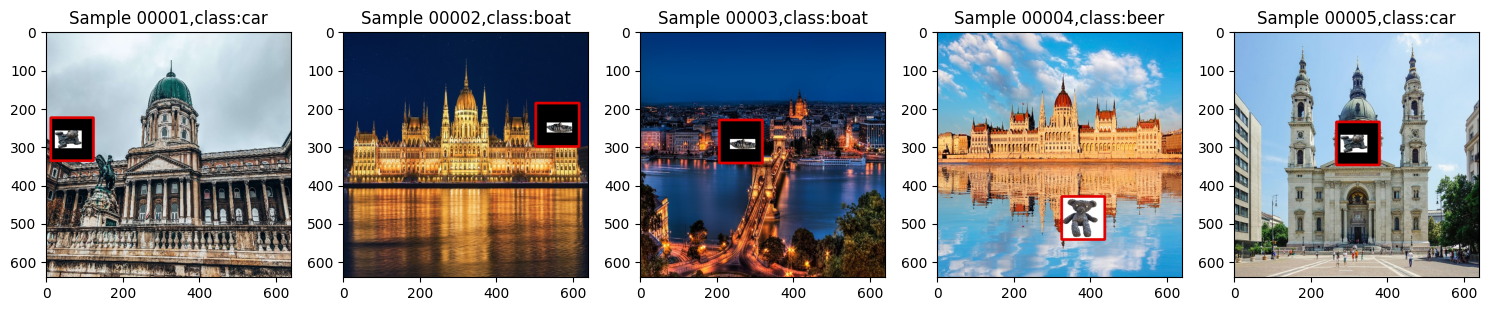

In [17]:
# ADD YOUR CODE HERE
# 写一个visualize_dataset函数,用来锚框
root_dir = 'dataset/dataset'
def visualize_dataset(root_dir, split='train', num_samples=5):
    images_dir = os.path.join(root_dir, split, 'images')
    labels_dir = os.path.join(root_dir, split, 'labels')

    # 获取数据集中的图像和标签文件列表
    image_files = sorted(os.listdir(images_dir))[:num_samples]
    label_files = sorted(os.listdir(labels_dir))[:num_samples]

    # 创建一个图像和标签文件路径的迭代器
    data_iterator = zip(image_files, label_files)

    # 创建一个包含num_samples个子图的图像
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, (image_file, label_file) in enumerate(data_iterator):
        # 读取图像和标签文件
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(labels_dir, label_file)
        image = cv2.imread(image_path)
        with open(label_path, 'r') as f:
            bbox_data = f.read().strip().split()

        # 检查bbox_data的长度是否是5的倍数
        if len(bbox_data) % 5 != 0:
            axes[i].text(0.5, 0.5, "Invalid bbox data", horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
            continue

        # 绘制锚框
        for j in range(0, len(bbox_data), 5):
            ob_num = int(bbox_data[j])
            x_center = float(bbox_data[j+1])
            y_center = float(bbox_data[j+2])
            width = float(bbox_data[j+3])
            height = float(bbox_data[j+4])
            x1 = int((x_center - width/2) * image.shape[1])
            y1 = int((y_center - height/2) * image.shape[0])
            x2 = int((x_center + width/2) * image.shape[1])
            y2 = int((y_center + height/2) * image.shape[0])
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 225), 5)

        # 将图像绘制在子图上
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # 设计标题
        if ob_num == 1 :
          axes[i].set_title(f"Sample 0000{i+1},class:boat")
        elif ob_num == 2 :
          axes[i].set_title(f"Sample 0000{i+1},class:car")
        elif ob_num == 3 :
          axes[i].set_title(f"Sample 0000{i+1},class:beer")

    plt.tight_layout()
    plt.show()

# 调用函数来展示前5个样本
visualize_dataset(root_dir, split='train', num_samples=5)

#-------------------------------------------------------------------------------------
# Show some visualizations of the created dataset
#visualize_dataset(train_dataset)

# 2. MODELS
For this assignment, you are required to create your own custom object detection model and compare its performance with an existing object detection model.

### 2.1. Custom Object Detection model

Create a Convolutional Neural Network based architecture that contains a backbone for feature extraction and two ouput branches:
- one for class probabilities (same size as the number of objects chosen, i.e. 3)
- another for bounding box regression (of size 4, due to the box coordinates x,y,w,h) or the chosen format

This is the main evaluation part of the assignment. Try combining different layers, try different hyper-parameters and include regularization.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# ADD YOUR CODE HERE

class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()

        # Define custom backbone

        # Detection layers

    def forward(self, x):
        #...
        return class_probs, bbox_regression

In [ ]:
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 3

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)

Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train your model
Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Make sure to optimize both classification and bounding box regression losses.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

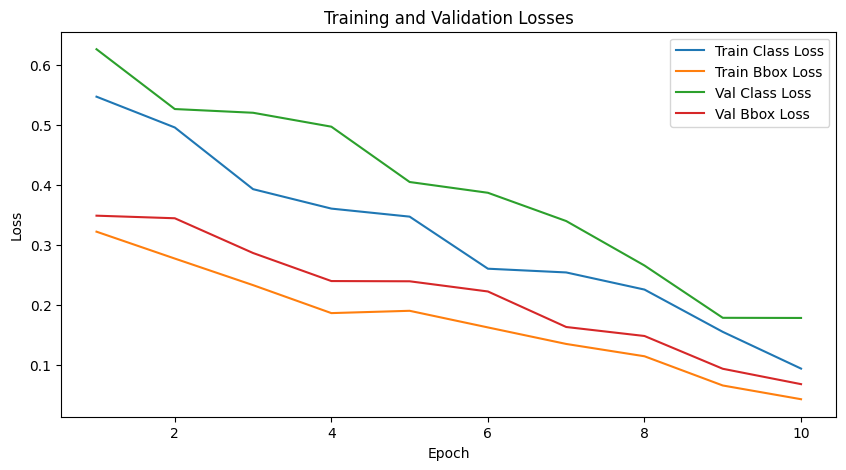

In [ ]:
# ADD YOUR CODE HERE

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10)
plot_losses(train_losses, val_losses)
# DO NOT TRY TO REPLICATE... this is an example

### 2.3. Evaulate and do inference with the trained custom model

Choose at least 3 metrics to evaluate your model (i.e. Precision, Recall, F-1, mean Average Precision, ...). Additionally, you can check the: inference speed, number of parameters, model size, etc.

Show performance metric visualizations.

Show some predictions of your trained model.

In [ ]:
# ADD YOUR CODE HERE

precision, recall, mAP = evaluate_test_set(model, test_loader, device)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mAP:.4f}')

In [ ]:
# ADD YOUR CODE HERE

visualize_predictions(model, test_dataset)

### 2.4. Load an existing object detection model
We recommend using YOLOv8, but you are free to use anything else (PyTorch based).

In [ ]:
# ADD YOUR CODE HERE

### 2.5. Fine-tune the existing object detection model
If YOLO is chosen, this can be done relatively easy by providing a data.yaml file (which follows a specific format, check github) and running the train script:

i.e. !yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640

or the functional way:
result = yolo.train(data = data_yaml_path, epochs = 40, batch = 10, patience = 30, weight_decay = 0.0005, project = save_path, name = 'train')

Make sure to show the losses and metrics visualizations. By default, YOLO should verbose those.

In [ ]:
# ADD YOUR CODE HERE

### 2.6 Evaluate the existing object detection model
Use the same metrics chosen on step 2.3.

In [ ]:
# ADD YOUR CODE HERE

# 3. COMPARISON
Compare the performance of the two models. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

In [ ]:
# ADD YOUR CODE HERE